## Concept Drift
In this notebook, we provide another use-case of our method.
We use a Resnet50 model (pre-trained on ImageNet) and leverage Text-To-Concept to:
+ check the s finding images which have some concepts (e.g., "a bear in trees").

This notebook has these sections:
+ <i>Preliminaries</i>: we import required libraries and load transformations.
+ <i>Resnet50</i>: we load the model and implement its necessary functions, enabling us to use `TextToConcept`.
+ <i>Linear Aligner</i>: we initiate `TextToConcept` object and load its linear aligner.
+ <i>Detect Drift</i>: we load ImageNet validation set and divide it into to halves:
    + the goal is to see if these two halves are different w.r.t. concept `indoors`.

### Preliminaries
In this section, we import the required libraries and initialize standard transformations necessary for loading datasets. It is worth mentioning that certain models require input normalization, while others do not.

In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import glob
import torchvision
import numpy as np
from torchvision import transforms, datasets
import json
from tqdm import tqdm
import torch
import pickle
from TextToConcept import TextToConcept
from my_utils import imagenet_classes

In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(224),
                                            torchvision.transforms.CenterCrop(224),
                                            torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)])

### Resnet50
In this part, we load Resnet50 model.

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
encoder = torch.nn.Sequential(*list(model.children())[:-1])
model.forward_features = lambda x : encoder(x)
model.get_normalizer = torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
model.has_normalizer = True

### Linear Aligner
In this section, we initiate ``TextToConcept`` object.

In [4]:
text_to_concept = TextToConcept(model, 'resnet50')
path = 'imagenet_resnet50_aligner.pth'
text_to_concept.load_linear_aligner(path)

### Detect Drift
we load ImageNet validation set and divide it into to halves and run `detect_drift` function w.r.t concept `indoors`.

In [5]:
dset = torchvision.datasets.ImageNet(root='/fs/cml-datasets/ImageNet/ILSVRC2012', split='val', transform=transform)

dset1 = torch.utils.data.Subset(dset, np.arange(25000))
dset2 = torch.utils.data.Subset(dset, np.arange(25000, 50000))

In [6]:
template = 'a photo of a {} indoors'
t_test, _1, _2 = text_to_concept.detect_drift(dset1, 'imagenet_val_1st', dset2, 'imagenet_val_2nd',
                                                   prompts=[template.format(c) for c in imagenet_classes])    

100%|████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [01:26<00:00, 36.26it/s]


#### Results
`t-test` results can be found in the next section. it seems these two halves are different!

In [7]:
t_test

[26.84267902610349, 1.3530698980865225e-157]

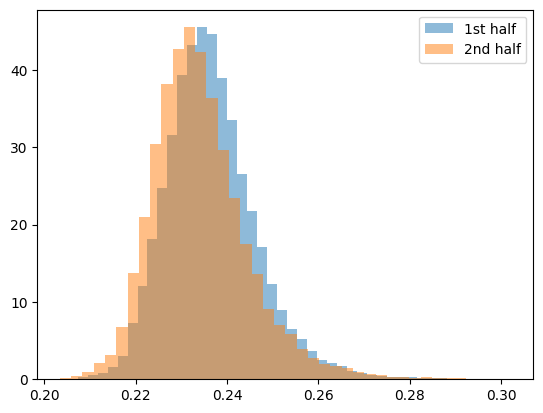

In [19]:
import matplotlib.pyplot as plt
plt.hist(_1, label='1st half', density=True, bins=40, alpha=0.5)
plt.hist(_2, label='2nd half', density=True, bins=40, alpha=0.5)
plt.legend()